1. **Load the data sets into data frames**

In [10]:
from sklearn.model_selection import train_test_split

## Constants

# Feature columns in the dataset
feature_columns = ['t', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2', 'x_3', 'y_3', 'v_x_3', 'v_y_3']

# Target columns in the datasets
target_columns = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

KeyboardInterrupt: 

In [2]:
import pandas as pd


def load_data_frame(path):
    """
    Load data set from file path
    :param path: the path of the file to turn into a data set
    :return: a created data set based on the header of the file
    """
    return pd.read_csv(path)


df_train = load_data_frame('X_train.csv')
df_test = load_data_frame('X_test.csv')

2. **Create the velocity columns for the test data set so that both dfs have the same columns**

In [3]:
def create_velocity_columns(data_frame):
    """
    Create the velocity columns for the data set
    :param data_frame: the data set to create the velocity columns for
    :return: the data set with the velocity columns created
    """
    for i in range(1, 4):
        data_frame['v_x_' + str(i)] = 0
        data_frame['v_y_' + str(i)] = 0

    return data_frame


df_test = create_velocity_columns(df_test)

3. **Rename the columns of the test data set to match the train data set**

In [4]:
df_test_prepared = df_test.rename(columns={
    'x0_1': 'x_1', 'y0_1': 'y_1', 'x0_2': 'x_2', 'y0_2': 'y_2', 'x0_3': 'x_3', 'y0_3': 'y_3'
})

4. **Create a linear model to predict the positions of the particles**

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


def linear_predict_positions(train_df, test_df):
    """
    Predict the positions of the particles using a linear model
    :return: the predicted positions of the particles
    """

    x_train = train_df[feature_columns]  # Use all features for training
    y_train = train_df[target_columns]  # Predict future positions

    x_test = test_df[feature_columns]  # Use the same structure as train for test predictions

    # Create a pipeline for scaling and regression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])

    # Train the model on the entire train set
    pipeline.fit(x_train, y_train)

    # Predict positions for the test set
    prediction = pipeline.predict(x_test)

    return prediction


y_pred_test = linear_predict_positions(df_train, df_test_prepared)

5. **Prepare the results for submission**

In [6]:
def prepare_results(df, columns):
    """
    Prepare the results for submission
    :param df: the data frame to prepare the results from
    :param columns: the columns to prepare the results for
    :return: the prepared results
    """
    results = pd.DataFrame(df, columns=columns)
    results['id'] = results.index
    return results


result_df = prepare_results(y_pred_test, target_columns)
result_df.to_csv('../data/y_test.csv', index=False)

6. **Plot the results**

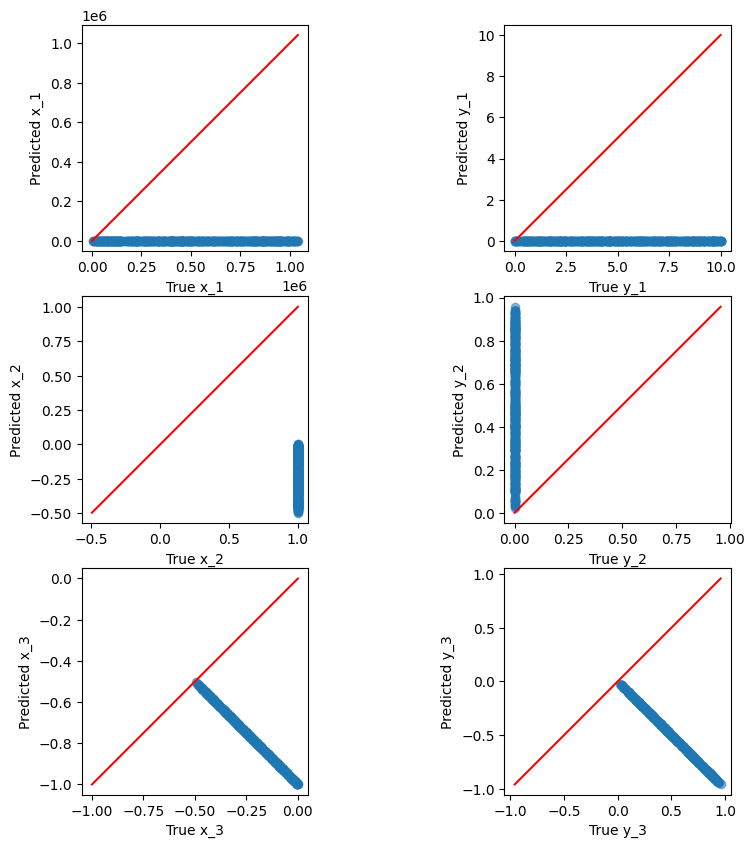

In [7]:
from matplotlib import pyplot as plt
import numpy as np


def plot_y_yhat(y_test, y_pred):
    """
    Plot the true values against the predicted values
    :param y_test: test values
    :param y_pred: model prediction values
    :return: 
    """
    # Ensure y_test and y_pred are NumPy arrays
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    # Column labels for positions
    labels = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

    # Maximum number of points to plot
    m = min(500, len(y_test))  # Ensure MAX is not larger than y_test length

    # Select random indices, ensuring they are within bounds
    idx = np.random.choice(len(y_test), m, replace=False)

    # Create a 10x10 figure
    plt.figure(figsize=(10, 10))

    # Plot each of the 6 position variables (x_1, y_1, x_2, y_2, x_3, y_3)
    for i in range(6):
        x0 = np.min([np.min(y_test[idx, i]), np.min(y_pred[idx, i])])  # Min value for the diagonal
        x1 = np.max([np.max(y_test[idx, i]), np.max(y_pred[idx, i])])  # Max value for the diagonal

        plt.subplot(3, 2, i + 1)
        plt.scatter(y_test[idx, i], y_pred[idx, i], alpha=0.5)  # Scatter plot
        plt.xlabel('True ' + labels[i])
        plt.ylabel('Predicted ' + labels[i])
        plt.plot([x0, x1], [x0, x1], color='red')  # Plot diagonal for reference
        plt.axis('square')

    # Save the figure
    # plt.savefig(plot_title + '.pdf')
    plt.show()


plot_y_yhat(df_test_prepared, y_pred_test)

In [1]:
import pandas as pd
import numpy as np


def custom_train_validation_test_split(df, test_size=None, validation_size=None, chunk_size=256, random_state=None,
                                       shuffle=True):
    """
    Splits the DataFrame into train, validation, and test sets using chunk sizes, ensuring that all rows in a chunk are
    assigned to the same set (train, validation, or test).
    
    Parameters:
    - df: The DataFrame to split.
    - test_size: The proportion or absolute number of the test set.
    - validation_size: The proportion or absolute number of the validation set.
    - train_size: The proportion or absolute number of the train set. If not specified, it's the remainder.
    - chunk_size: The size of chunks to use for splitting.
    - random_state: Seed for random number generation.
    - shuffle: Whether to shuffle the chunks before splitting.
    
    Returns:
    - train_set, validation_set, test_set: Splits of the input DataFrame.
    """
    # Determine the number of samples in multiple of chunk_size
    nr_chunks = len(df) // chunk_size
    
    nr_test_chunks, nr_validation_chunks = 0, 0
    # Ensure the split sizes are proportions if they are not given as such
    if isinstance(test_size, float):
        nr_test_chunks = int(np.ceil(test_size * nr_chunks)) # Number of chunks
    if isinstance(validation_size, float):
        nr_validation_chunks = int(np.ceil(validation_size * nr_chunks)) # Number of chunks

    nr_train_chunks = nr_chunks - nr_test_chunks - nr_validation_chunks
    
    # Create an array of chunk indices
    chunk_indices = np.arange(0, nr_chunks)
    
    # Shuffle the chunks if required
    if shuffle:
        if random_state is not None:
            np.random.seed(random_state)
        np.random.shuffle(chunk_indices)
    
    # Split the chunk indices into train, validation, and test indices
    train_indices = chunk_indices[:nr_train_chunks]
    validation_indices = chunk_indices[nr_train_chunks:nr_train_chunks + nr_validation_chunks]
    test_indices = chunk_indices[nr_train_chunks + nr_validation_chunks:]
    
    
    # Helper function to extract chunks by indices
    def get_chunks(indices, chunk_size):
        return pd.concat([df.iloc[i * chunk_size: (i + 1) * chunk_size] for i in indices])
    
    
    # Split the DataFrame into train, validation, and test sets based on chunked indices
    train_set = get_chunks(train_indices, chunk_size)
    validation_set = get_chunks(validation_indices, chunk_size)
    test_set = get_chunks(test_indices, chunk_size)
    
    return train_set, validation_set, test_set

# Example Usage:
data = {'A': np.arange(100), 'B': np.random.randn(100)}  # Example DataFrame
df = pd.DataFrame(data)
print("Original DataFrame:\n", df)

train_set, validation_set, test_set = custom_train_validation_test_split(
    df,
    test_size=0.2,  # 20% of the data for test
    validation_size=0.1,  # 10% for validation
    chunk_size=5,  # Use chunk size of 5
    random_state=42,  # For reproducibility
    shuffle=True  # Shuffle the data before splitting
)

print("Train Set:\n", train_set)
print("Validation Set:\n", validation_set)
print("Test Set:\n", test_set)


Original DataFrame:
      A         B
0    0  0.297784
1    1  0.071887
2    2  0.863900
3    3 -2.461987
4    4  0.860579
..  ..       ...
95  95  1.834299
96  96  0.723836
97  97 -0.535507
98  98  0.340105
99  99 -1.423560

[100 rows x 2 columns]
Train Set:
      A         B
0    0  0.297784
1    1  0.071887
2    2  0.863900
3    3 -2.461987
4    4  0.860579
..  ..       ...
95  95  1.834299
96  96  0.723836
97  97 -0.535507
98  98  0.340105
99  99 -1.423560

[70 rows x 2 columns]
Validation Set:
      A         B
20  20  0.217465
21  21 -1.359886
22  22  0.644654
23  23  0.347985
24  24 -0.431306
60  60  0.910029
61  61 -0.314988
62  62 -1.715977
63  63  1.893160
64  64  0.451348
Test Set:
      A         B
35  35 -0.358863
36  36  0.052306
37  37 -0.338601
38  38  0.520577
39  39  1.155624
50  50 -1.446173
51  51 -0.367080
52  52 -0.156512
53  53 -1.186354
54  54  0.648293
70  70  0.975953
71  71  1.079366
72  72  0.787655
73  73  0.054212
74  74  0.752283
30  30  0.177510
31  31 -